In [1]:
import sys
import os
sys.path.append("../")


In [2]:
from tqdm import tqdm
import numpy as np
import cv2
from copy import deepcopy
from PIL import Image
from diffusion_policy.gym_util.multistep_wrapper import MultiStepWrapper
from diffusion_policy.env.robomimic.robomimic_lowdim_wrapper import RobomimicLowdimWrapper
from diffusion_policy.model.common.rotation_transformer import RotationTransformer
import robomimic.utils.file_utils as FileUtils
import robomimic.utils.env_utils as EnvUtils
import robomimic.utils.obs_utils as ObsUtils

/home/cspark/.conda/envs/robodiff/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
def create_env(env_meta, obs_keys):
    ObsUtils.initialize_obs_modality_mapping_from_dict(
        {'low_dim': obs_keys})
    env = EnvUtils.create_env_from_metadata(
        env_meta=env_meta,
        render=False, 
        render_offscreen=False,
        use_image_obs=False, 
    )
    return env

In [4]:
def create_disturbance_function(task_name):
    if task_name == "lift":
        def disturbance_function(object_pos_quat, speed):
            return object_pos_quat + np.array([0.0, 0.0, 0.0, 0, 0, 0, 0])
    elif task_name == "square":
        def disturbance_function(object_pos_quat):
            return object_pos_quat + np.array([0.0, 0.0, 0.0, 0, 0, 0, 0])
    else:
        raise ValueError(f"Invalid task name: {task_name}")
    
    return disturbance_function

In [5]:
# task_name = "lift"
task_name = "square"
dataset_type = "ph"
dataset_path = f"../data/robomimic/datasets/{task_name}/{dataset_type}/low_dim_abs.hdf5"
dataset_path = os.path.expanduser(dataset_path)
env_meta = FileUtils.get_env_metadata_from_dataset(dataset_path)

#Inlucde this since it is abs true
obs_keys = ['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_gripper_qpos']
env_meta['env_kwargs']['controller_configs']['control_delta'] = False
rotation_transformer = RotationTransformer('axis_angle', 'rotation_6d')

robomimic_env = create_env(
                    env_meta=env_meta, 
                    obs_keys=obs_keys
                )

disturance_function = create_disturbance_function(task_name)

render_hw = (128, 128)
env_n_obs_steps = 2
env_n_action_steps = 8
max_steps = 400
render_camera_name = 'agentview'
multistep_env = MultiStepWrapper(
                    RobomimicLowdimWrapper(
                        env=robomimic_env,
                        obs_keys=obs_keys,
                        init_state=None,
                        render_hw=render_hw,
                        render_camera_name=render_camera_name
                    ),
                    n_obs_steps=env_n_obs_steps,
                    n_action_steps=env_n_action_steps,
                    max_episode_steps=max_steps
                )

Created environment with name NutAssemblySquare
Action size is 7


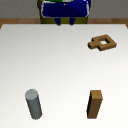

In [6]:
obs = multistep_env.reset()
state = multistep_env.env.env.get_state()

frame = multistep_env.render(mode='rgb_array')
img = Image.fromarray(frame)
img.show()

object_pos_quat = state['states'][10:17] # x, y, z, qx, qy, qz, qw
robot0_gripper_qpos = state['states'][8:10]
robot_q_pos = state['states'][1:8]

In [7]:
print(object_pos_quat)

[-0.11053649  0.19422196  0.89       -0.82373424  0.          0.
  0.56697611]


In [8]:
multistep_env.env.env.get_observation()

{'object': array([-0.11053649,  0.19422196,  0.89      ,  0.        ,  0.        ,
         0.56697611, -0.82373424,  0.00268112, -0.18901995,  0.10390322,
         0.82054198,  0.57063365,  0.02579102,  0.02056568]),
 'robot0_eef_pos': array([-0.11819245,  0.00467303,  0.99268498]),
 'robot0_eef_quat': array([ 0.99944415,  0.00482273,  0.03290519, -0.00231776]),
 'robot0_gripper_qpos': array([ 0.020833, -0.020833])}

In [9]:
# object_pos_lst = list()

# for i in tqdm(range(100)):
#     multistep_env.reset()
#     state = multistep_env.env.env.get_state()
#     object_pos_quat = state['states'][10:13]
#     object_pos_lst.append(object_pos_quat)

# object_pos_lst = np.array(object_pos_lst)
# print(object_pos_lst.shape)



[ 0.020833 -0.020833]


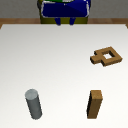

In [13]:
new_state = deepcopy(state)
new_object_pos_quat = object_pos_quat + np.array([0.1, 0.0, 0.0, 0, 0, 0, 0])
new_state['states'][10:17] = new_object_pos_quat
multistep_env.env.env.reset_to(new_state)
state = multistep_env.env.env.get_state()
print(state['states'][8:10])
frame = multistep_env.render(mode='rgb_array')
img = Image.fromarray(frame)
img.show()


In [ ]:
multistep_env.step(np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.99,]]))
frame = multistep_env.render(mode='rgb_array')
state = multistep_env.env.env.get_state()
print(state['states'][8:10])
img = Image.fromarray(frame)
img.show()


In [ ]:
obs, reward, doen, info = multistep_env.step(np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.99,]]))
frame = multistep_env.render(mode='rgb_array')
state = multistep_env.env.env.get_state()
print(state['states'][8:10])
new_state = {k:v for k,v in deepcopy(state).items() if k != 'model'}
new_state['states'][10:17] = object_pos_quat + np.array([0.000, 0.0, 0.0, 0, 0, 0, 0])
multistep_env.env.env.reset_to(new_state)
print(state['states'][8:10])
img = Image.fromarray(frame)
img.show()


In [ ]:
print(new_state.keys())

In [ ]:
state['states']

In [ ]:
multistep_env.reset()
print(multistep_env.env.env.get_observation())
print(multistep_env.env.env.get_state()['states'])

In [ ]:
print(obs.shape)

In [ ]:
"Nut" in str(type(multistep_env.env.env.env))

In [ ]:
rewards = multistep_env.env.env.env.staged_rewards()
print(rewards)